### Preprocessing

In [1]:
# import relevant statistical packages
import numpy as np
import pandas as pd

# import data visualisation packages
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# statsmodels
# import statsmodels as sm
from statsmodels.api import OLS
from statsmodels.tools.tools import add_constant

import warnings
warnings.filterwarnings('ignore')


In [2]:
# pandas version
pd.__version__

'1.4.2'

### 8 (a) Generating normally distribution predictor X and noise vector $\epsilon$

In [3]:
# set random seed for reproducibility
np.random.seed(1)

X = np.random.normal(size=100)
epsilon = np.random.normal(size=100)

In [4]:
len(X), len(epsilon)

(100, 100)

### 8 (b) Generating response vector $Y$ = $\beta_0$ + $\beta_1$ $X$ + $\beta_2$ $X^2$ + $\beta_3$ $X^3$ + $\epsilon$

In [5]:
BETA0 = 2.0
BETA1 = -2.0
BETA2 = 3.0
BETA3 = 2.5
Y = BETA0 + (BETA1*X) + (BETA2*pow(X, 2)) + (BETA3*pow(X, 3)) + epsilon

In [6]:
df = pd.DataFrame([X, Y]).T \
    .set_axis(['X', 'Y'], axis = 1)
# df.columns = ['X', 'Y']
df.head()

,X,Y
0,1.624345,16.934254
1,-0.611756,4.998390
2,-0.528172,3.928377
3,-1.072969,5.105132
4,0.865408,3.041389


### 8 (c) use forward stepwise selection to select a model containing the predictors $X$ , $X^2$ , ... $X^{10}$ . What is the model obtained according to $C_p$ ? Report the coefficients of the model obtained.

Using `mlxtend` package to perform feature selection and plotting steps

Source: https://rasbt.github.io/mlxtend/

In [7]:
# import custom packages
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score as r2
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_linear_regression as PLS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

In [8]:
# create predictors
dfX = pd.DataFrame([X, pow(X, 2), pow(X, 3), pow(X, 4), pow(X, 5), pow(X, 6), pow(X, 7), pow(X, 8), pow(X, 9), pow(X, 10)]).T
dfX.columns = ['X', 'X_2', 'X_3', 'X_4', 'X_5', 'X_6', 'X_7', 'X_8', 'X_9', 'X_10']
dfX.head()

,X,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10
0,1.624345,2.638498,4.285832,6.961671,11.308158,18.368354,29.836551,48.464863,78.723675,127.874436
1,-0.611756,0.374246,-0.228947,0.140060,-0.085683,0.052417,-0.032066,0.019617,-0.012001,0.007342
2,-0.528172,0.278965,-0.147342,0.077822,-0.041103,0.021710,-0.011466,0.006056,-0.003199,0.001689
3,-1.072969,1.151262,-1.235268,1.325403,-1.422116,1.525886,-1.637228,1.756694,-1.884878,2.022415
4,0.865408,0.748930,0.648130,0.560897,0.485404,0.420073,0.363534,0.314605,0.272262,0.235617


In [9]:
# target 'Y'
dfY = pd.DataFrame(df['Y'])
dfY.head()

,Y
0,16.934254
1,4.998390
2,3.928377
3,5.105132
4,3.041389


In [10]:
# import sklearn.metrics as sk_metrics
# sk_metrics.get_scorer_names()

#### Best subset selection (Exhaustive Sequential Selector)

In [11]:
# best subset (EFS)
efs = EFS(LinearRegression(), 
          min_features = 1, 
          max_features = 4, 
          scoring = 'neg_mean_squared_error', 
          cv = 0)

In [12]:
# fit EFS
efs.fit(dfX, dfY)

# get the final set of features
efs.best_feature_names_

Features: 385/385

('X', 'X_2', 'X_3', 'X_6')

In [13]:
# get features list
features = efs.best_feature_names_
idx = efs.best_idx_

feat_list = pd.concat([pd.DataFrame([features]).T, pd.DataFrame([idx]).T], axis = 1)
feat_list.columns = ['Features', 'Index']
avg_score = pd.DataFrame()
for i in idx:
    avg_score = avg_score.append(pd.DataFrame([efs.subsets_[i]['avg_score']]))
avg_score.columns = ['Average Score']
avg_score.reset_index(drop=True,inplace=True)
feat_list = pd.concat([feat_list, avg_score], axis=1, ignore_index=True)
feat_list.columns = ['Features', 'Index', 'Average Score']
feat_list

,Features,Index,Average Score
0,X,0,-23.924017
1,X_2,1,-27.433574
2,X_3,2,-12.387446
3,X_6,5,-33.588373


In [14]:
# performing linear regression on best features
dfX_reg = dfX[feat_list['Features']]

lm_best = LinearRegression().fit(dfX_reg, dfY)
final_coefs = pd.DataFrame(lm_best.coef_).T
final_coefs = pd.concat([feat_list['Features'], final_coefs], axis = 1)
final_intercept = pd.DataFrame([lm_best.intercept_] * len(feat_list))
final_coefs = pd.concat([final_coefs, final_intercept], axis = 1)
final_coefs.columns = ['Features', 'Coefficients', 'Intercept']
final_coefs

,Features,Coefficients,Intercept
0,X,-2.089924,2.276949
1,X_2,2.657467,2.276949
2,X_3,2.605378,2.276949
3,X_6,0.020949,2.276949


In [15]:
# MSE
lmpred = lm_best.predict(dfX_reg)
print("Mean Squared Error: ", round(mean_squared_error(dfY, lmpred), 3))

Mean Squared Error:  0.798


**Therefore, the best equation through best subset selection is $Y$ = 2.128035 - 2.089924 $X$ + 2.657467 $X^2$ + 2.605378 $X^3$ + 0.020949 $X^6$ and the mean squared error is 0.798.**

#### Forward Sequential Selection (SFS)

In [16]:
# define function to perform forward stepwise selection using OLS
def forward_selection(data, target, significance_level=0.05):
    initial_features = data.columns.tolist()
    best_features = []
    while (len(initial_features)>0):
        remaining_features = list(set(initial_features)-set(best_features))
        new_pval = pd.Series(index=remaining_features)
        for new_column in remaining_features:
            model = OLS(target, add_constant(data[best_features+[new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]
        min_p_value = new_pval.min()
        if(min_p_value<significance_level):
            best_features.append(new_pval.idxmin())
        else:
            break
    return best_features

In [17]:
# perform forward stepwise selection
forward_selection(dfX, dfY)

['X_3', 'X_2', 'X', 'X_6']

In [18]:
# Sequential Forward Selection(sfs)
sfs = SFS(LinearRegression(), 
          k_features = 4,
          forward = True,
          floating = False,
          scoring = 'r2',
          cv = 0)

In [19]:
# fit SFS
sfs.fit(dfX, dfY)

# get the final set of features
sfs.k_feature_names_  

('X', 'X_2', 'X_3', 'X_6')

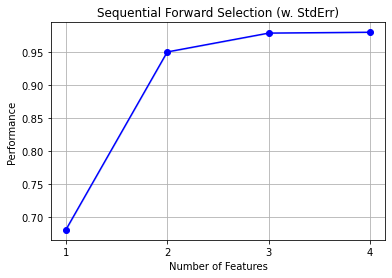

In [20]:
# plot SFS
fig1 = plot_sfs(sfs.get_metric_dict(), kind = 'std_dev')
plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

In [21]:
# get features list
feat = sfs.k_feature_idx_

feat_list = pd.DataFrame()
for i in feat:
    print(dfX.columns[i])
    feat_list = feat_list.append(pd.DataFrame([dfX.columns[i]]))
feat_list.reset_index(inplace=True, drop=True)
feat_list.columns = ['Features']
feat_list

X
X_2
X_3
X_6


,Features
0,X
1,X_2
2,X_3
3,X_6


In [22]:
# performing linear regression on best features
dfX_reg = dfX[feat_list['Features']]

lm_best = LinearRegression().fit(dfX_reg, dfY)
final_coefs = pd.DataFrame(lm_best.coef_).T
final_coefs = pd.concat([feat_list['Features'], final_coefs], axis = 1)
final_intercept = pd.DataFrame([lm_best.intercept_] * len(feat_list))
final_coefs = pd.concat([final_coefs, final_intercept], axis = 1)
final_coefs.columns = ['Features', 'Coefficients', 'Intercept']
final_coefs

,Features,Coefficients,Intercept
0,X,-2.089924,2.276949
1,X_2,2.657467,2.276949
2,X_3,2.605378,2.276949
3,X_6,0.020949,2.276949


In [23]:
# MSE
lmpred = lm_best.predict(dfX_reg)
print("Mean Squared Error: ", round(mean_squared_error(dfY, lmpred), 3))

Mean Squared Error:  0.798


1.  Forward sequential selection return the same features as the best subset (efs).
2.  Forward stepwise selection model equation is $Y$ = 2.276949 - 2.089924 $X$ + 2.657467 $X^2$ + 2.605378 $X^3$ + 0.020949 $X^6$ and the mean squared error is 0.798.

### 8 (d) Repeat (c) using backwards stepwise selection. How does your answer compare to the results in (c)?

In [24]:
# define function for backward stepwise selection
def backward_elimination(data, target,significance_level = 0.05):
    features = data.columns.tolist()
    while(len(features)>0):
        features_with_constant = add_constant(data[features])
        p_values = OLS(target, features_with_constant).fit().pvalues[1:]
        max_p_value = p_values.max()
        if(max_p_value >= significance_level):
            excluded_feature = p_values.idxmax()
            features.remove(excluded_feature)
        else:
            break 
    return features

In [25]:
# perform backward stepwise selection
backward_elimination(dfX, dfY)

['X', 'X_2', 'X_5', 'X_6', 'X_7', 'X_9']

In [26]:
# Sequential backward selection(sbs)
sbs = SFS(LinearRegression(),
         k_features = (3, 6),
         forward = False,
         floating = False,
         cv=0)

In [27]:
# fit SBS
sbs.fit(dfX, dfY)

# get the final set of features
sbs.k_feature_names_  

('X', 'X_2', 'X_5', 'X_6', 'X_7', 'X_9')

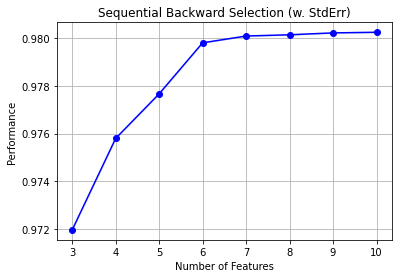

In [28]:
# plot SBS
fig1 = plot_sfs(sbs.get_metric_dict(), kind = 'std_dev')
plt.title('Sequential Backward Selection (w. StdErr)')
plt.grid()
plt.show()

In [29]:
# get features list
feat = sbs.k_feature_idx_

feat_list = pd.DataFrame()
for i in feat:
    print(dfX.columns[i])
    feat_list = feat_list.append(pd.DataFrame([dfX.columns[i]]))
feat_list.reset_index(inplace=True, drop=True)
feat_list.columns = ['Features']
feat_list

X
X_2
X_5
X_6
X_7
X_9


,Features
0,X
1,X_2
2,X_5
3,X_6
4,X_7
5,X_9


In [30]:
# performing linear regression on best features
dfX_reg = dfX[feat_list['Features']]

lm_best = LinearRegression().fit(dfX_reg, dfY)
final_coefs = pd.DataFrame(lm_best.coef_).T
final_coefs = pd.concat([feat_list['Features'], final_coefs], axis = 1)
final_intercept = pd.DataFrame([lm_best.intercept_] * len(feat_list))
final_coefs = pd.concat([final_coefs, final_intercept], axis = 1)
final_coefs.columns = ['Features', 'Coefficients', 'Intercept']
final_coefs

,Features,Coefficients,Intercept
0,X,-1.283175,2.334272
1,X_2,2.492363,2.334272
2,X_5,2.144319,2.334272
3,X_6,0.031013,2.334272
4,X_7,-0.614978,2.334272
5,X_9,0.056794,2.334272


In [31]:
# MSE
lmpred = lm_best.predict(dfX_reg)
print("Mean Squared Error: ", round(mean_squared_error(dfY, lmpred), 3))

Mean Squared Error:  0.782


**Therefore, the best equation through best subset selection is $Y$ = 2.334272 - 1.283175 $X$ + 2.492363 $X^2$ + 2.144319 $X^5$ - 0.031013 $X^6$ - 0.614978 $X^7$ + 0.056794 $X^{9}$ and the mean squared error is 0.782.**

### 8 (e) Lasso regression

In [32]:
# import custom packages
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [33]:
# split dataset into train/test
X_train, X_test, y_train, y_test = train_test_split(dfX, dfY, test_size = 0.3, random_state = 42)

In [36]:
# define lambda grid
lambdas = (np.logspace(10, -100, num = 200))

In [37]:
# standardisation
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [38]:
# finding the best lambda using CV
from sklearn.linear_model import LassoCV

lmlassoCV = LassoCV(alphas = lambdas, cv = 5, random_state = 2023).fit(X_train_scaled, y_train)
lmlassoCValpha = lmlassoCV.alpha_
print("Best lambda: ", round(lmlassoCValpha, 4))

Best lambda:  0.0247


In [39]:
# performing lasso regression using best lambda
lmlasso = Lasso(alpha = lmlassoCValpha, 
                fit_intercept=True).fit(X_train_scaled, y_train)

lmlasso_MSE = mean_squared_error(y_test, lmlasso.predict(X_test_scaled))
print('MSE for best lambda: ', round(lmlasso_MSE, 3))

MSE for best lambda:  1.291


In [40]:
intercept_list = pd.DataFrame([lmlasso.intercept_] * len(dfX.columns))
coef_list = pd.concat([intercept_list, pd.DataFrame([lmlasso.coef_]).T], axis = 1)
coef_list.reset_index(inplace=True, drop=True)
coef_list.columns = ['Intercept', 'Coefficients']
coef_list.index = coef_list.index+1

# select features with Coefficiens != 0
coef_list[coef_list['Coefficients'] != 0]

,Intercept,Coefficients
1,4.916213,-1.487156
2,4.916213,3.846053
3,4.916213,5.933036
5,4.916213,1.244558
10,4.916213,0.093708


**Therefore, the best equation through lasso regression is $Y$ = 4.916213 - 1.487156 $X$ + 3.846053 $X^2$ + 5.933036 $X^3$ + 1.244558 $X^5$ + 0.093708 $X^{10}$ and the mean squared error is 1.291.**

### 8 (f) Best subset selection and lasso regression for for $Y$ = $\beta_0$ + $\beta_7$ $X^7$ + $\epsilon$

In [82]:
BETA7 = 23.457
Y7 = BETA0 + (BETA7*pow(X, 7)) + epsilon

**Best subset selection**

In [83]:
dfX7 = pd.DataFrame([pow(X, 7)]).T
dfX7.columns = ['X^7']
dfY7 = pd.DataFrame([Y7]).T
dfY7.columns = ['Y']

In [84]:
lm = LinearRegression()
efs = EFS(lm, min_features=1, max_features=1, scoring='r2', cv = 5).fit(dfX7, dfY7)

Features: 1/1

In [85]:
SCORE = pd.DataFrame()
for k in efs.get_metric_dict():
    score = efs.get_metric_dict()[k]['std_err']
    SCORE = SCORE.append([score])

SCORE.columns = ['std err']
SCORE.reset_index(drop=True, inplace=True)

In [86]:
minSCORE = SCORE.loc[SCORE['std err'] == min(SCORE['std err'])]
minSCORE

,std err
0,0.000324


In [87]:
efs.subsets_[0]

{'feature_idx': (0,),
 'cv_scores': array([0.99999972, 0.99996709, 0.99999913, 0.99999952, 0.9983734 ]),
 'avg_score': 0.9996677699131767,
 'feature_names': ('X^7',)}

In [88]:
features = efs.best_feature_names_
idx = efs.best_idx_

feat_list = pd.concat([pd.DataFrame([features]).T, pd.DataFrame([idx]).T], axis = 1)
feat_list.columns = ['Features', 'Index']
avg_score = pd.DataFrame()
for i in idx:
    avg_score = avg_score.append(pd.DataFrame([efs.subsets_[i]['avg_score']]))
avg_score.columns = ['Average Score']
avg_score.reset_index(drop=True,inplace=True)
feat_list = pd.concat([feat_list, avg_score], axis=1, ignore_index=True)
feat_list.columns = ['Features', 'Index', 'Average Score']
feat_list

,Features,Index,Average Score
0,X^7,0,0.999668


In [89]:
# performing linear regression on best features
dfX_reg = dfX[feat_list['Features']]

lm_best = LinearRegression().fit(dfX_reg, dfY)
final_coefs = pd.DataFrame(lm_best.coef_).T
final_coefs = pd.concat([feat_list['Features'], final_coefs], axis = 1)
final_intercept = pd.DataFrame([lm_best.intercept_])
final_coefs = pd.concat([final_coefs, final_intercept], axis = 1)
final_coefs.columns = ['Features', 'Coefficients', 'Intercept']
final_coefs

,Features,Coefficients,Intercept
0,X^7,0.089695,4.784395


In [90]:
lmpred = lm_best.predict(dfX_reg)
print("Mean Squared Error: ", round(mean_squared_error(dfY, lmpred), 3))

Mean Squared Error:  18.038


**Therefore, the best equation through best subset selection is $Y$ = 4.784395 + 0.089695 $X^7$ and the mean squared error is 18.038.**

**Lasso regression**

In [91]:
# standardisation
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(dfX7)
dfX7_scaled = scaler.transform(dfX7)

In [92]:
n = 100
lambdas = (np.logspace(10, -2, num=100))

In [93]:
coefs = []
MSE = []
for k in lambdas:
    lassomod = Lasso(alpha=k, fit_intercept=True).fit(dfX7_scaled,dfY7)
    coefs.append(lassomod.coef_)
    MSE.append(mean_squared_error(dfY7, lassomod.predict(dfX7_scaled)))

In [94]:
coefPD = pd.DataFrame(coefs)

In [95]:
coefPD.head()

,0
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [96]:
coefPD.shape

(100, 1)

In [97]:
lassomod.intercept_

array([-8.95252135])

In [98]:
coefPD = pd.concat([pd.DataFrame([lassomod.intercept_]*100), coefPD], axis=1)
coefPD.columns = ['Intercept', 'X^7']
coefPD.shape

(100, 2)

In [99]:
coefPD.head()

,Intercept,X^7
0,-8.952521,0.0
1,-8.952521,0.0
2,-8.952521,0.0
3,-8.952521,0.0
4,-8.952521,0.0


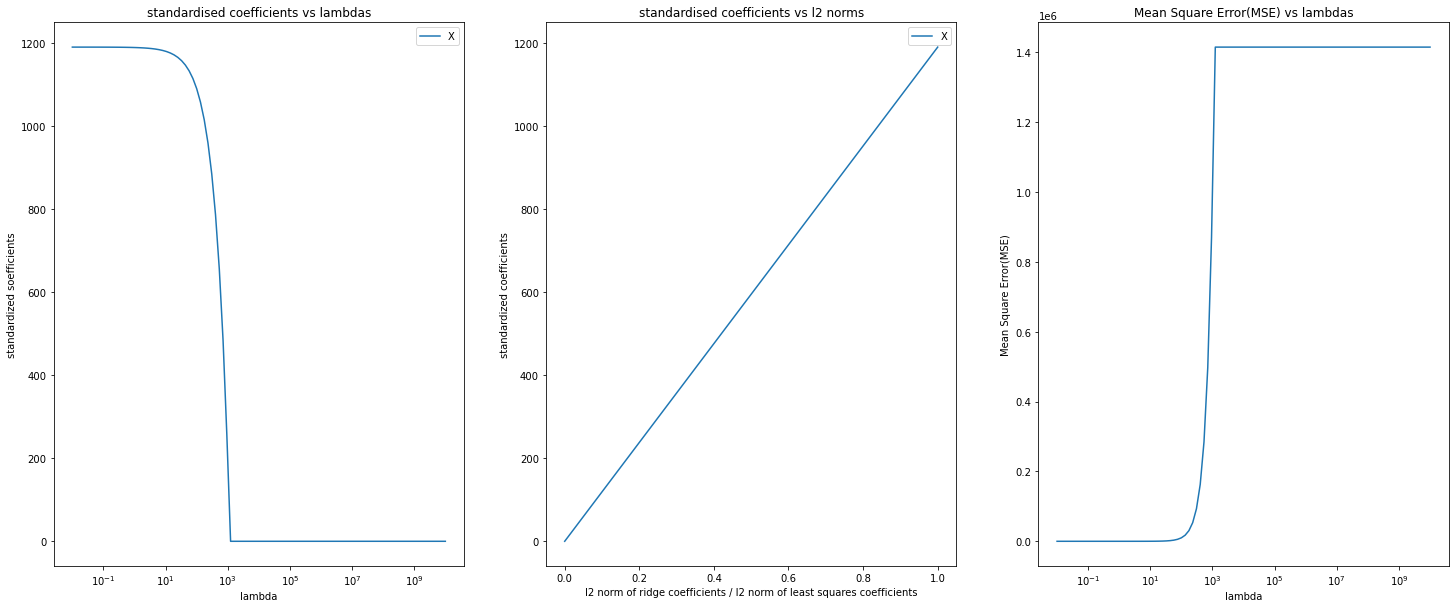

In [100]:
# plt.xkcd()
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25,10))

# indexing the only coefficient
idx = np.argpartition(np.abs(coefs[-1]), -1)[-1:]

# standardised coefficients vs lambdas
ax1.plot(lambdas, coefs)
ax1.set_xscale('log')
ax1.set_xlabel('lambda')
ax1.set_ylabel('standardized soefficients')
ax1.set_title('standardised coefficients vs lambdas')
ax1.legend(np.array(ax1.get_lines())[idx], dfX.columns[idx])

# standardised coefficients vs l2 norms
l2norm = np.linalg.norm(coefs[-1])
l2coefs = np.linalg.norm(coefs/l2norm, axis=1)
ax2.plot(l2coefs, coefs)
ax2.set_xlabel('l2 norm of ridge coefficients / l2 norm of least squares coefficients')
ax2.set_ylabel('standardized coefficients')
ax2.set_title('standardised coefficients vs l2 norms')
ax2.legend(np.array(ax2.get_lines())[idx], dfX.columns[idx]);

# 'Mean Square Error(MSE) vs lambdas
ax3.plot(lambdas, MSE)
ax3.set_xscale('log')
ax3.set_xlabel('lambda')
ax3.set_ylabel('Mean Square Error(MSE)')
ax3.set_title('Mean Square Error(MSE) vs lambdas');

In [101]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dfX7, dfY7, test_size=0.3, random_state=42)

In [102]:
# standardisation
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [103]:
# MSE with only the intercept
lmMSEintercept = np.mean(pow((y_train.mean()-y_test), 2))
print("MSE with only the intercept: ", lmMSEintercept)

# MSE for lambda = 0; this is similar to least squares linear regression
lmlasso0 = Lasso(alpha=0, fit_intercept=True).fit(X_train_scaled, y_train)
lmpredict0 = lmlasso0.predict(X_test_scaled)
lmMSE0 = mean_squared_error(y_test, lmpredict0)
print("MSE at lambda = 0: ", lmMSE0)

# MSE for lambda = 1
lmridge1 = Lasso(alpha=1, fit_intercept=True).fit(X_train_scaled, y_train)
lmpredict1 = lmridge1.predict(X_test_scaled)
lmMSE1 = mean_squared_error(y_test, lmpredict1)
print("MSE at lambda = 1: ", lmMSE1)

# MSE for lambda = 4
lmlasso4 = Lasso(alpha=4, fit_intercept=True).fit(X_train_scaled, y_train)
lmpredict4 = lmlasso4.predict(X_test_scaled)
lmMSE4 = mean_squared_error(y_test, lmpredict4)
print("MSE at lambda = 4: ", lmMSE4)

# MSE for lambda = pow(10, 10)
lmlasso1010 = Lasso(alpha=pow(10, 10), fit_intercept=True).fit(X_train_scaled, y_train)
lmpredict1010 = lmlasso1010.predict(X_test_scaled)
lmMSE1010 = mean_squared_error(y_test, lmpredict1010)
print("MSE at lambda = 10^10: ", lmMSE1010)

MSE with only the intercept:  Y    26931.921085
dtype: float64
MSE at lambda = 0:  1.1346290601263855
MSE at lambda = 1:  1.146009895322998
MSE at lambda = 4:  1.340895697538563
MSE at lambda = 10^10:  26931.921085017148


In [104]:
# finding the best lambda using CV
from sklearn.linear_model import LassoCV

lmlassoCV = LassoCV(alphas=lambdas, cv=10).fit(X_train_scaled, y_train)
lmlassoCValpha = lmlassoCV.alpha_
print("Best lambda: ", lmlassoCValpha)

Best lambda:  0.12328467394420634


In [105]:
# performing lasso regression using best lambda
lmlasso = Lasso(alpha=lmlassoCValpha, fit_intercept=True).fit(X_train_scaled, y_train)
lmlasso_MSE = mean_squared_error(y_test, lmlasso.predict(X_test_scaled))
print('MSE for best lambda: ', round(lmlasso_MSE, 3))

MSE for best lambda:  1.135


In [106]:
intercept_list = pd.DataFrame([lmlasso.intercept_])
coef_list = pd.concat([intercept_list, pd.DataFrame([lmlasso.coef_]).T], axis = 1)
coef_list.reset_index(inplace=True, drop=True)
coef_list.columns = ['Intercept', 'Coefficients']
coef_list.index = coef_list.index+1
coef_list

,Intercept,Coefficients
1,-21.577303,1417.862041


**Therefore, the best equation through lasso regression is $Y$ = -21.577303 + 1417.882041 $X^7$ and the mean squared error is 1.135.**

**This suggests that when p<<n, then lasso provides a better fit (even if the intercept is quite off from its true value)
than best subset selection as suggested by the lower MSE through lasso regression. But, as p  increases to the point of
p$\approx$n, then best subset selection is more preferred, albeit it comes at a cost of greater computational requirement.**